# Tutorial

This tutorial provides a full walk-through on how to apply EPI to a
example problem. We only assume that you already installed `eulerpi`. The
tutorial is divided in four sections:

1.  [Introduction](#introduction)
2.  [Define your data](#define-your-data)
3.  [Define your model](#define-your-model)
4.  [Inference](#inference)

Let\'s start!

## Introduction

EPI is an algorithm meant to solve stochastic inverse problems. Stochastic inverse problems arise in different contexts, but the main application is likely the parameter calibration task. Consider the following situation: we have a deterministic simuation model $s$ that maps parameters $q$ to model predictions (data) $s(q)=y$, but we don't know exactly what the correct parameters are. We have, however, some observations of the data $\{y_i\}$. We could try to find a set of parameters $\{q_i\}$ s.t. $s(q_i)=y_i$, but this seems unnecessarily tidious. Instead, we are going to assume the data points are independent samples from a random variable $\mathcal{Y}$, i.e. $y_i \overset{\text{i.i.d.}}{\sim}Y$. Instead of trying to find a set of parameters $\{q_i\}$ explaining the observations, we now try to find the distribution of the parameter random variable $\mathcal{Q}$ that fulfills
\begin{equation}
    s(\mathcal{Q})=\mathcal{Y}.
\end{equation}
So the goal is to derive the parameter distribution $\Phi_\mathcal{Q}$ from the data distribution $\Phi_\mathcal{Y}$. This is the inverse of what our (forward) model is providing. To solve the inverse problem, EPI uses the multi-dimension transformation formula
\begin{equation}
    \Phi_\mathcal{Q}(q) = \Phi_\mathcal{Y}(s(q)) \left\lvert\frac{ds}{dq}(q)\right\rvert.
\end{equation}


That's enough maths for now - let's take a look at an example! We start with something simple: the average temperatures in different locations, i.e. a model for the dependence of the temperature $y$ on the latitude $q$. In the real world, problems with a known continous data distribution are rare. Instead, we often rely on discrete measurements. Hence, EPI starts with discrete data points as input and derives a continous distribution using Kernel Density Estimation (KDE) techniques. From this data distribution the EPI algorithm derives the parameter distribution. To close the cycle between the data and parameters, we can again sample from this distribution and use the forward model to get a finite sample of the parameters.

With this picture in mind, we can start to implement the temperature
problem in `eulerpi`.

### Define your data

Your data needs to be stored in a `.csv` file in the following format:

``` text
datapoint_1_dim_1, datapoint_1_dim_2,..., datapoint_1_dim_N
datapoint_2_dim_1, datapoint_2_dim_2,..., datapoint_2_dim_N
...
datapoint_M_dim_1, datapoint_M_dim_2,..., datapoint_M_dim_N
```

Each of the lines defines an N-dimensional datapoint. The `.csv` file will be loaded into an $\mathrm{R}^{M \times N}$ numpy array in EPI. Alternatively, you can provide an $\mathrm{R}^{M \times N}$ numpy array directly.

In the following we will use the example data `TemperatureData.csv`. It has 455 datapoints with two dimensions each.
Nonuniform data is not supported in EPI.
Please download it from: [Download Temperature Data](https://systems-theory-in-systems-biology.github.io/EPI/_downloads/090dff47c31e511d0522cc9cc0cdb502/TemperatureData.csv) and make sure that it is located in the same path as this notebook. 

### Define your model

Next you need to define your model. The most basic way is to derive from
the `eulerpi.core.model.Model` base class.

In [3]:
import importlib
import jax.numpy as jnp
import numpy as np
from eulerpi.core.model import Model

A model inhereting from `Model` must implement the methods
- `forward`
- `jacobian`

Additionally, the attributes 
- `param_dim`
- `data_dim`
- `PARAM_LIMITS`
- `CENTRAL_PARAM`

must be defined by the model.

This provides the sampling algorithm with sensible starting values and boundary values for the parameters. The jacobian for the temperature model is derived analytically and implemented explicitly. Note that the model class has to be defined in its own file - in this case, copy the following code into a file with the name `temperature.py`.

In [4]:
from typing import Optional
from eulerpi.core.model import Model
import numpy as np
import jax.numpy as jnp

class Temperature(Model):

    param_dim = 1
    data_dim = 1

    PARAM_LIMITS = np.array([[0, np.pi / 2]])
    CENTRAL_PARAM = np.array([np.pi / 4.0])

    def __init__(
        self,
        central_param: np.ndarray = CENTRAL_PARAM,
        param_limits: np.ndarray = PARAM_LIMITS,
        name: Optional[str] = None,
        **kwargs,
    ) -> None:
        super().__init__(central_param, param_limits, name=name, **kwargs)

    def forward(self, param):
        low_T = -30.0
        high_T = 30.0
        res = jnp.array(
            [low_T + (high_T - low_T) * jnp.cos(jnp.abs(param[0]))]
        )
        return res

    def jacobian(self, param):
        return jnp.array([60.0 * jnp.sin(jnp.abs(param[0]))])


### Using inference

Now we can now use `eulerpi` to infer the parameter distribution from the data. By default, the `inference` method uses Markov chain Monte Carlo (MCMC) sampling (this can be changed using the inference_type argument). `inference` returns a tuple containing samples from the parameter Markov chain $q_i$, the corresponding data points $y_i = s(q_i)$, the estimated densities $\Phi_Q (q_i)$ scaled by a constant $c$, and a `ResultManager` object that can be used to load and manipulate the results of EPI.

In [5]:
from eulerpi.core.inference import inference
from eulerpi.examples.temperature import Temperature # TODO

# create a temperature model object
model = Temperature()
# run EPI
overall_params, sim_results, density_evals, result_manager = inference(
    model = model,
    data = "TemperatureData.csv",
)

100%|██████████| 2500/2500 [00:42<00:00, 58.38it/s]


While MCMC sampling works well in general, it is especially usefull in high-dimensional parameter spaces. `eulerpi` provides another way of performing inference which is more taylored to low- or ideally one-dimensional parameter spaces as we have for this model: dense grid evaluations. We can tell inference to use dense grid evaluations using the `inference_type` argument:


In [6]:
from eulerpi.core.inference_types import InferenceType

# run EPI with dense grid evaluations:
overall_params, sim_results, density_evals, result_manager = inference(
    model = model,
    data = "TemperatureData.csv",
    inference_type = InferenceType.DENSE_GRID,
    run_name = "dense_grid_run",
    num_grid_points = 100,
)

`eulerpi` creates a uniform grid specified by the parameter limits of the model with `num_grid_points` grid points. The variable `overall_params` now contains the parameter values of the grid. We used the argument `run_name` to tell `eulerpi` to not overwrite the results of the previous run, but to save the results in a different folder with the name `dense_grid_run` instead.

### Loading inference results

Depending on the complexity of your model the sampling can take a long time. Due to this reason, not only the final results but also intermediate sampling results are saved. You can find them in the folder `Applications/Temperature/`. Don't worry - we don't need to search for the files ourself. The class `ResultManager` takes care of this. To load back in the results of a previous inference run, we can use the following snippet:

In [7]:
from eulerpi.core.result_manager import ResultManager

# create a result manager object
result_manager = ResultManager(
    model_name = model.name,
    run_name = "dense_grid_run",
    slices = [np.array([0])],
)
    
# save the results
overall_params, sim_results, density_evals = result_manager.load_inference_results()

The argument `run_name` is the name of the run you want to load - if no `run_name` was specified when calling inference, this is `default_run`. We'll come to slicing in a moment - notice for now the the `ResultManager` object needs to be given the information which parameters where inferred.

### Plotting

`eulerpi` provides some basic plotting functionality to visualize the inference results. The following snippet gives an example of this:

<Axes: >

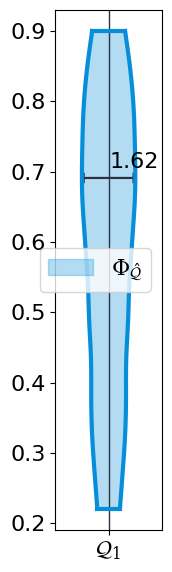

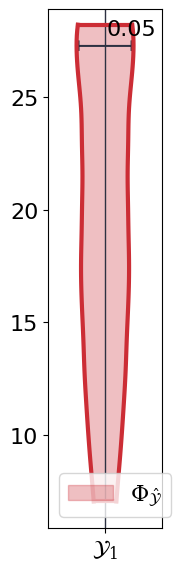

In [8]:
from eulerpi.core.plotting import sample_violin_plot

# plot the inferred parameter distribution
sample_violin_plot(model)
# plot the inferred data distribution
sample_violin_plot(model, what_to_plot="data")

The two plots correspond to the inferred parameter distribution $\hat{\Phi}_{\mathcal{Q}}$ and a KDE of the pushforward of the inferred sample, i.e. $s(\hat{q_i})$. We will come back to the plotting function when we defined a more interesting model:

## Advanced features
### A more intricate model

To make things a little more interesting, we will consider a simple model for infectious diseases. The model divides the population into four compartments - succeptible to the disease, exposed, infected, and removed. Hence, this type of model is often referred to as an SEIR model. The SEIR model is governed by the following set of equations:
$$
\begin{aligned}
    \frac{d[S]}{dt}= & -q_1[S][I]\\
    \frac{d[E]}{dt}= & q_1[S][I] - q_2[E]\\
    \frac{d[I]}{dt}= & q_2[E]  - q_3[I]\\
    \frac{d[R]}{dt}= & q_3[I]\\
\end{aligned}
$$
The parameter $q_1$ corresponds to an infection rate, $q_2$ determines the timescale of the incubation period, and $q_3$ is the recovery rate. We aim to estimate these parameters based on time series data of the incidence, i.e. the evaluation of $I$ at certain time points $t_i$. An implementation of this model can be found in `eulerpi.examples.corona`:


In [10]:
from eulerpi.core.model import JaxModel

class Corona(JaxModel):
    """ """

    param_dim = 3
    data_dim = 4

    PARAM_LIMITS = np.array([[-4.5, 0.5], [-2.0, 3.0], [-2.0, 3.0]])
    CENTRAL_PARAM = np.array([-1.8, 0.0, 0.7])

    def __init__(
        self,
        central_param: np.ndarray = CENTRAL_PARAM,
        param_limits: np.ndarray = PARAM_LIMITS,
        name: Optional[str] = None,
        **kwargs,
    ) -> None:
        super().__init__(central_param, param_limits, name=name, **kwargs)

    @classmethod
    def forward(cls, log_param):
        param = jnp.power(10, log_param)
        xInit = jnp.array([999.0, 0.0, 1.0, 0.0])

        def rhs(t, x, param):
            return jnp.array(
                [
                    -param[0] * x[0] * x[2],
                    param[0] * x[0] * x[2] - param[1] * x[1],
                    param[1] * x[1] - param[2] * x[2],
                    param[2] * x[2],
                ]
            )

        term = dx.ODETerm(rhs)
        solver = dx.Kvaerno5()
        saveat = dx.SaveAt(ts=[0.0, 1.0, 2.0, 5.0, 15.0])
        stepsize_controller = dx.PIDController(rtol=1e-5, atol=1e-5)

        try:
            ode_sol = dx.diffeqsolve(
                term,
                solver,
                t0=0.0,
                t1=15.0,
                dt0=0.1,
                y0=xInit,
                args=param,
                saveat=saveat,
                stepsize_controller=stepsize_controller,
            )
            return ode_sol.ys[1:5, 2]

        except Exception as e:
            logger.warning("ODE solution not possible!", exc_info=e)
            return np.array([-np.inf, -np.inf, -np.inf, -np.inf])



### Artificial data creation

Sometimes, it is hard to tell if the stochastic inverse problem is even well-defined for a given problem - for instance, is the mapping $s$ defined by the evaluation of the SEIR model at four different time points bijective? `eulerpi` provides some tools to at least perform some sanity checks.

One easy way to gain some understanding of the well-posedness of a given problem is to generate some artificial parameters $\{q_i\}$, and use the model to create artificial data $y_i = s(q_i)$ from these parameters. Then, calling `inference` on the artificial data and comparing the inference results to the original parameters should give us some intuition if the problem is roughly well-posed.

We can use the abstract class `ArtificialModelInterface` to create an artificial model. For the SEIR model, this is implemented in `eulerpi.examples.corona` too:

In [12]:
from eulerpi.core.model import ArtificialModelInterface

class CoronaArtificial(Corona, ArtificialModelInterface):
    PARAM_LIMITS = np.array([[-2.5, -1.0], [-0.75, 0.75], [0.0, 1.5]])

    def __init__(
        self,
        central_param: np.ndarray = Corona.CENTRAL_PARAM,
        param_limits: np.ndarray = PARAM_LIMITS,
        name: Optional[str] = None,
        **kwargs,
    ) -> None:
        super().__init__(central_param, param_limits, name=name, **kwargs)

    def generate_artificial_params(self, num_samples):
        lower_bound = np.array([-1.9, -0.1, 0.6])
        upper_bound = np.array([-1.7, 0.1, 0.8])

        true_param_sample = lower_bound + (
            upper_bound - lower_bound
        ) * np.random.rand(num_samples, 3)

        return true_param_sample

Using this, we can create some artificial data:

In [13]:
from eulerpi.examples.corona import CoronaArtificial

model = CoronaArtificial()

corona_artificial_params = model.generate_artificial_params(1000)
corona_artificial_data = model.generate_artificial_data(corona_artificial_params)

### Marginal distributions and slicing

As for virtually any method, the cost of estimating a high-dimensional joint multivariate distribution with EPI grows exponentially in the number of dimensions. `eulerpi` provides a possible remedy, if some parameter groupings are stochastically independent of each other. In this case, the marginal distributions of these groupings can be evaluated directly - we call this process *slicing*. We can use this feature by passing the parameter groupings, i.e. the slices, as an argument to the inference method:

In [14]:
overall_params, sim_results, density_evals, result_manager = inference(
    model = model,
    data = corona_artificial_data,
    inference_type = InferenceType.DENSE_GRID,
    slices = [np.array([0, 1]), np.array([2])],
    num_grid_points = 100,
)

The code snippet above corresponds to the assumption that the grouping $(\mathcal{Q}_1,\mathcal{Q}_2)$ is independent of $\mathcal{Q}_3$ and computes the corresponding marginal distributions $\phi_{\mathcal{Q}_1, \mathcal{Q}_2}$ and $\phi_{\mathcal{Q_3}}$.